In [ ]:
# /// script
# requires-python = ">=3.11"
# dependencies = [
#   "requests",
#   "pandas",
#   "seaborn",
#   "matplotlib",
# ]
# ///


In [1]:
#importing necessary libraries for data manipulation and visualization
import requests  # library for making HTTP requests
import os  # library for interacting with the operating system
import pandas as pd  # library for data manipulation and analysis
import json  # library for working with JSON data
import traceback  # library for error handling and debugging
import sys  # library for system-specific parameters and functions
import matplotlib.pyplot as plt  # library for creating static, animated, and interactive visualizations
import seaborn as sns  # library for statistical graphics and data visualization
   

In [2]:
# Get the file name from the command line argument
file_name = sys.argv[1]


In [ ]:
# Set API proxy token from environment variable
AIPROXY_TOKEN = os.environ.get("AIPROXY_TOKEN")
print(AIPROXY_TOKEN)

# Set API request headers with JSON content type and authorization token
headers = {"content-Type":"application/json",  "Authorization": f"Bearer {AIPROXY_TOKEN}",}

# Set API endpoint URL for chat completions
url = "https://aiproxy.sanand.workers.dev/openai/v1/chat/completions"

# Set model for chat completions
model = "gpt-4o-mini"

In [4]:
# Placeholder for README content
readme_data = {
    "dataset_overview": "",
    "inferences": "",
    "preprocessing_steps": "",
    "analysis_list": [],
    "charts": []
}

metaData = []


In [6]:
def correct_the_code(code, error, functions, instructions, function_name="generate_chart"):
    """
    Sends a request to the LLM to correct the code with the given error.
    
    Args:
    code (str): The original code.
    error (str): The error message.
    functions (list): A list of functions to be used by the LLM.
    instructions (str): Instructions for the LLM.
    function_name (str): The name of the function to be called. Defaults to "generate_chart".
    
    Returns:
    dict: The response from the LLM.
    """
    # Combine the code, error, and metadata into a single string
    code_with_error = code + "\n" + error + "\n" + str(metaData)
    
    # Create the JSON data for the request
    json_data = {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "system",
                "content": instructions
            },
            {
                "role": "user",
                "content": code_with_error
            }
        ],
        "functions": functions,
        "function_call": {"name": function_name}
    }
    
    # Send the request and get the response
    r = requests.post(url, headers=headers, json=json_data)
    response = r.json()
    return response

def execute_code(code, functions, instructions, limit=3, function_name="generate_chart"):
    """
    Executes the given code and attempts to correct it if it fails.
    
    Args:
    code (str): The code to be executed.
    functions (list): A list of functions to be used by the LLM.
    instructions (str): Instructions for the LLM.
    limit (int): The maximum number of attempts to correct the code. Defaults to 3.
    function_name (str): The name of the function to be called. Defaults to "generate_chart".
    
    Returns:
    None
    """
    attempt = 0
    success = False

    # Attempt to execute the code until it succeeds or the limit is reached
    while attempt < limit and not success:
        try:
            # Attempt to execute the code
            exec(code)
            success = True
        except Exception as e:
            # If the code fails, increment the attempt counter and print the error
            attempt += 1
            print(f"Attempt {attempt} failed: {e}")
            error = traceback.format_exc()
            print(error)
            
            # Send the code and error to the LLM to correct it
            response = correct_the_code(code, error, instructions, functions, function_name)
            code = json.loads(response['choices'][0]['message']['function_call']['arguments'])['python_code']

    # If all attempts fail, print a message
    if not success:
        print("All attempts failed.")

In [ ]:
#instructions
instructions_to_make_charts = (
    "You are provided with a dataset loaded in a dataframe named `df`, along with its metadata. "
    "Your task is to analyze the dataset and create a chart that answers the provided question or illustrates the relevant insight. "
    "The dataset is huge the selection of chart type and axes must be considered accordingly . "
    "Choose an appropriate chart type based on the data and the question. "
    "Before plotting check if the size of datapoints that is to be plooted is not too large so as it fit in a canvas. If larger use other techniques"
    "Consider the size of the dataset; if it's large, aggregate or filter the data before plotting. "
    "Allowed to use matplotlib or seaborn libraries for plotting. But do not overlap"
    "Ensure the chart is well-labeled, easy to interpret, and exported as a PNG file. (must export as png)"
    "Preprocessing or transformation of the data may be required to generate the chart. "
    "The code must not contain comments."
)

instructions_to_infer_the_column_dtypes = (
"Analyse the given dataset. The first line is the header, and subsequent lines "
"are sample data. Columns may have uncleaned data; ignore those cells. "
"consider column as the data type of column"
"Infer the data type by considering the majority: 'integer', 'float', 'string', 'boolean', and 'date'."
)

instructions_to_handle_missing_values = (
    "The dataset has been already loaded in the environment as a pandas dataframe 'df'. "
    "The dataset may have missing values. Handle the missing values in the dataset. "
    "The dataset is huge the selection of chart type and axes must be considered accordingly . "
    "You have to generate Python code to handle missing values in the dataset. The code should not contain any comments. "
    "The handling of missing values should consider the data type of the column as well as the context and semantics of the data. "
    "Your choice of handling missing values should be logical and based on the column's meaning and its relevance to the dataset's domain. "
    "Think of it as what would a data scientist do in this situation. How does it impact the analysis and if its retention in data convey some meaning"
    "You can use the following libraries: pandas. "
    "The code should be generic, adaptable to any dataset, and should not rely on hardcoding column names. "
    "The column names and data types of the dataset are provided in the metadata. "
)


user_prompt_to_handle_mv = (
    "### Missing Values Data:\n" + str(missing_values) + "\n"
    "### Metadata of the Dataset:\n" + str(metaData) + "\n\n"
    "Your task:\n"
    "1. Handle only those columns which have missing values.\n"
    "2. Use logical and context-aware methods to handle missing values:\n"
    "   - For numeric columns, choose strategies such as mean, median, or interpolation based on the column's context and relevance. Reason its importance in the dataset.\n"
    "   - For categorical columns, consider using the mode, 'Unknown', or another domain-specific default value where applicable. Think of the implications it would have\n"
    "   - If the column contains data with domain-specific meaning (e.g., 'Country', 'Happiness Score'), avoid generic imputations (like the global mean) and choose approaches that respect the data's semantics. For instance, consider using regional or grouped means or flagging missing values instead of filling them.\n"
    "   - You may consider dropping columns with a high percentage of missing values if they are not relevant to the analysis.\n"
    "  - Ensure that the handling of missing values aligns with the context of the data and the domain of the dataset.\n"
    " - You may consider dropping rows with missing values if they are not significant in number and do not affect the analysis.\n"
    "3. Provide clear reasoning for every step taken to handle missing values in the dataset, ensuring it aligns with the context of the data.\n\n"
    "### Additional Notes:\n"
    "The Python code must be generic and should work for any dataset. It should not hardcode column names and should dynamically handle missing values based on the provided metadata."
)

instructions_to_generate_questions = (
    "You are the most intelligent and thoughtful person who can analyze a dataset and identify the most impactful questions that can be asked from its columns."
    "You may choose to use depending on the type of dataset and the domain of the dataset"
    "Charts would be created to answer the questions so these questions should be relevant to be answered by charts"
    "You are highly practical and know which questions can provide the most value and insights when visualized using charts."
    "Your task is to identify three most important and insightful questions that can be asked and effectively visualized from the given dataset."
    "The questions should cover the purpose of the dataset comprehensively and utilize the columns in a way that provides a holistic understanding of the dataset as a whole."
    
)

instructions_to_make_charts = (
"You are provided with a dataset loaded in a dataframe named `df`, along with its metadata. "
"Your task is to analyze the dataset and create a chart that answers the provided question or illustrates the relevant insight. "
"Choose an appropriate chart type based on the data and the question. "
"The dataset is huge the selection of chart type and axes must be considered accordingly . "
"Consider the size of the dataset; if it's large, aggregate or filter the data before plotting. "
"Allowed to use matplotlib or seaborn libraries for plotting. But do not overlap"
"Ensure the chart is well-labeled, easy to interpret, and exported as a PNG file. (must export as png)"
"Preprocessing or transformation of the data may be required to generate the chart. "
"The code must not contain comments."
)

analysis_prompt = (
        "You have been given the chart generated from the analysis of the dataset to answer the question "
        "Your task is the do the analysis of the chart image and infer the answer to the question"
        "The insights you discovered"
        "The implications of your findings i.e. what to do with the insights"
    )

prompt = (
    "You have been given the chart generated from the analysis of the dataset to answer the question "
    "question :" + question + "."
    "Your task is the do the analysis of the chart image and infer the answer to the question"
)

readme_prompt = (
    "You are an expert in data analysis storytelling. Generate a detailed README.md file for the given project. "
    "The README should include: You may reorganize the sections to clearl put up the analysis results and work\n\n"
    "1. Dataset Overview: Describe the dataset, including its size, columns, and notable patterns or observations.\n"
    "2. Insights: Mention inferences that can be made from the dataset profile.\n"
    "3. Preprocessing Steps: Explain the data preprocessing techniques applied, including missing value handling.\n"
    "4. Types of Analysis: List the analyses performed and explain why each type of analysis was chosen.\n"
    "5. Include the png saved with file_name of the chart image. Strictly use the file_name as the image source. its a png file"
    "6. Charts: For each generated chart, include its name, description, and purpose.\n\n"
    "7. You have been given the anslysis results as well so write the anaysis result- answer, insight and the future implications"
    "8. Ensure everything is correct and the README is well-structured and easy to read and that it include all details of the analysis Focus more on results of analysis.\n\n"
    "Input Data:\n"
    f"{json.dumps(data, indent=2)}"
)


    

In [ ]:
import requests
import os
import pandas as pd
import json
import traceback
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import base64

FILE_NAME = 'media.csv'

AIPROXY_TOKEN = os.environ.get("AIPROXY_TOKEN")
URL = "https://aiproxy.sanand.workers.dev/openai/v1/chat/completions"
HEADERS = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {AIPROXY_TOKEN}"
}
MODEL = "gpt-4o-mini"


def get_aiproxy_token():
    """Fetch the AI Proxy token from environment variables."""
    if not AIPROXY_TOKEN:
        raise ValueError("AIPROXY_TOKEN not found in environment variables.")
    return AIPROXY_TOKEN


def read_sample_data(file_name, lines=10):
    """Read and return the first few lines of the dataset as a string."""
    with open(file=file_name, mode='r') as f:
        return ''.join([f.readline().strip() for _ in range(lines)])

def load_csv_with_fallback(file_name, encodings=['utf-8', 'ISO-8859-1', 'latin1']):
    """Attempt to load a CSV file with multiple encodings."""
    for encoding in encodings:
        try:
            df = pd.read_csv(file_name, encoding=encoding)
            print(f"Successfully loaded with encoding: {encoding}")
            return df
        except UnicodeDecodeError as e:
            print(f"Failed to load with encoding: {encoding}, error: {e}")
    raise UnicodeDecodeError(f"All attempts to load the file {file_name} with the provided encodings failed.")

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def correct_the_code(code, error, meta_data, instructions, functions, function_name="generate_chart"):
    """Send a code snippet and error details to the AI API for correction."""
    instructions = f"while executing these instructions : {instructions} I encountered an error. Please correct the error"
    code_with_error = code + "\n" + error + "\n" + str(meta_data)
    json_data = {
        "model": "gpt-4o-mini",
        "messages": [
            {"role": "system", "content": instructions},
            {"role": "user", "content": code_with_error}
        ],
        "functions": functions,
        "function_call": {"name": function_name}
    }
    response = requests.post(URL, headers=HEADERS, json=json_data)
    return response.json()

def execute_code(code, meta_data, instructions, functions, function_name="generate_chart", attempts=3):
    """Execute the provided code with retry logic."""
    attempt = 0
    success = False

    while attempt < attempts and not success:
        try:
            exec(code)
            success = True
        except Exception as e:
            attempt += 1
            print(f"Attempt {attempt} failed: {e}")
            error = traceback.format_exc()
            print(error)
            response = correct_the_code(code, error, meta_data, instructions, functions,function_name)
            code = json.loads(response['choices'][0]['message']['function_call']['arguments'])['python_code']

    if not success:
        print("All attempts to execute the code failed.")

def save_readme(content):
    with open("README.md", "w") as f:
        f.write(content)

INSTRUCTIONS_TO_INFER_COLUMNS = (
"Analyse the given dataset. The first line is the header, and subsequent lines "
"are sample data. Columns may have uncleaned data; ignore those cells. "
"consider column as the data type of column"
"Infer the data type by considering the majority: 'integer', 'float', 'string', 'boolean', and 'date'."
)

INSTRUCTIONS_TO_HANDLE_MISSING_VALUES = (
    "The dataset has been already loaded in the environment as a pandas dataframe 'df'. "
    "The dataset may have missing values. Handle the missing values in the dataset. "
    "The dataset is huge the selection of chart type and axes must be considered accordingly . "
    "You have to generate Python code to handle missing values in the dataset. The code should not contain any comments. "
    "The handling of missing values should consider the data type of the column as well as the context and semantics of the data. "
    "Your choice of handling missing values should be logical and based on the column's meaning and its relevance to the dataset's domain. "
    "Think of it as what would a data scientist do in this situation. How does it impact the analysis and if its retention in data convey some meaning"
    "You can use the following libraries: pandas. "
    "The code should be generic, adaptable to any dataset, and should not rely on hardcoding column names. "
    "The column names and data types of the dataset are provided in the metadata. "
)

INSTRUCTIONS_TO_GENERATE_QUESTIONS = (
    "You are the most intelligent and thoughtful person who can analyze a dataset and identify the most impactful questions that can be asked from its columns."
    "You may choose to use depending on the type of dataset and the domain of the dataset"
    "Charts would be created to answer the questions so these questions should be relevant to be answered by charts"
    "You are highly practical and know which questions can provide the most value and insights when visualized using charts."
    "Your task is to identify three most important and insightful questions that can be asked and effectively visualized from the given dataset."
    "The questions should cover the purpose of the dataset comprehensively and utilize the columns in a way that provides a holistic understanding of the dataset as a whole."    
)

INSTRUCTIONS_TO_MAKE_CHARTS = (
    "You are provided with a dataset loaded in a dataframe named `df`, along with its metadata. "
    "Your task is to analyze the dataset and create a chart that answers the provided question or illustrates the relevant insight. "
    "Choose an appropriate chart type based on the data and the question. "
    "The dataset is huge the selection of chart type and axes must be considered accordingly . "
    "Consider the size of the dataset; if it's large, aggregate or filter the data before plotting. "
    "Allowed to use matplotlib or seaborn libraries for plotting. But do not overlap"
    "Ensure the chart is well-labeled, easy to interpret, and exported as a PNG file. (must export as png)"
    "Preprocessing or transformation of the data may be required to generate the chart. "
    "The code must not contain comments."
    )

INSTRUCTIONS_TO_ANALYSE_CHARTS = (
            "You have been given the chart generated from the analysis of the dataset to answer the question "
            "Your task is the do the analysis of the chart image and infer the answer to the question"
            "The insights you discovered"
            "The implications of your findings i.e. what to do with the insights"
        )

INSTRUCTIONS_TO_CREATE_README = (
    "You are an expert in data analysis storytelling. Generate a detailed README.md file for the given project. "
        "The README should include: You may reorganize the sections to clearl put up the analysis results and work\n\n"
        "1. Dataset Overview: Describe the dataset, including its size, columns, and notable patterns or observations.\n"
        "2. Insights: Mention inferences that can be made from the dataset profile.\n"
        "3. Preprocessing Steps: Explain the data preprocessing techniques applied, including missing value handling.\n"
        "4. Types of Analysis: List the analyses performed and explain why each type of analysis was chosen.\n"
        "5. Include the png saved with file_name of the chart image. Strictly use the file_name as the image source. its a png file"
        "6. Charts: For each generated chart, include its name, description, and purpose.\n\n"
        "7. You have been given the anslysis results as well so write the anaysis result- answer, insight and the future implications"
        "8. Ensure everything is correct and the README is well-structured and easy to read and that it include all details of the analysis Focus more on results of analysis.\n\n"
        
)

def infer_column_types(INSTRUCTIONS_TO_INFER_COLUMNS, data):
    """Infer column data types using the AI API."""
    json_data = {
        "model": "gpt-4o-mini",
        "messages": [
            {"role": "system", "content": INSTRUCTIONS_TO_INFER_COLUMNS },
            {"role": "user", "content": data}
        ],
        "functions": [
            {
                "name": "get_column_type",
                "description": "Identify column names and their data type from the dataset",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "column_metadata": {
                            "type": "array",
                            "description": "Metadata for each column",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "column_name": {"type": "string", "description": "The name of the column"},
                                    "column_type": {"type": "string", "description": "The data type of the column"}
                                },
                                "required": ["column_name", "column_type"]
                            },
                            "minItems": 1
                        },
                        "dataset_overview": {
                            "type": "string",
                            "description": "Overview of the dataset and its structure"
                        }
                    },
                    "required": ["column_metadata", "dataset_overview"]
                }
            }
        ],
        "function_call": {"name": "get_column_type"}
    }

    try:
        response = requests.post(url=URL, headers=HEADERS, json=json_data)
        response.raise_for_status()
        result = response.json()
        metadata = json.loads(result['choices'][0]['message']['function_call']['arguments'])
        return metadata['column_metadata'], metadata['dataset_overview']
    except requests.exceptions.RequestException as e:
        print(f"HTTP Request failed: {e}")
        raise
    except KeyError as e:
        print(f"Unexpected response format: {e}")
        raise

def handle_missing_values(INSTRUCTIONS_TO_HANDLE_MISSING_VALUES, df, column_metadata):
    missing_values = df.isnull().sum()
    print("\nMissing Values:\n", missing_values)

    functions = [
        {
            "name": "handle_missing_values",
            "description": "Handle missing values in the dataset",
            "parameters" : {
                "type": "object",
                "required": ["python_code", "dependencies","steps_taken_to_handle_mv"],
                "properties" :{
                    "python_code" :{
                        "type": "string",
                        "description": "Python code to handle missing values in the dataset"
                    },
                    "dependencies":{
                        "type": "string",
                        "description": "comma separated list of dependencies used to preprocess this chart"

                    },
                    "steps_taken_to_handle_mv":{
                        "type": "string",
                        "description": "Elaborative description of Steps taken to handle missing values in the dataset"

                    },

                }
            
            }

        }
    ]


    prompt = (
        "### Missing Values Data:\n" + str(missing_values) + "\n"
        "### Metadata of the Dataset:\n" + str(column_metadata) + "\n\n"
        "Your task:\n"
        "1. Handle only those columns which have missing values.\n"
        "2. Use logical and context-aware methods to handle missing values:\n"
        "   - For numeric columns, choose strategies such as mean, median, or interpolation based on the column's context and relevance. Reason its importance in the dataset.\n"
        "   - For categorical columns, consider using the mode, 'Unknown', or another domain-specific default value where applicable. Think of the implications it would have\n"
        "   - If the column contains data with domain-specific meaning (e.g., 'Country', 'Happiness Score'), avoid generic imputations (like the global mean) and choose approaches that respect the data's semantics. For instance, consider using regional or grouped means or flagging missing values instead of filling them.\n"
        "   - You may consider dropping columns with a high percentage of missing values if they are not relevant to the analysis.\n"
        "  - Ensure that the handling of missing values aligns with the context of the data and the domain of the dataset.\n"
        " - You may consider dropping rows with missing values if they are not significant in number and do not affect the analysis.\n"
        "3. Provide clear reasoning for every step taken to handle missing values in the dataset, ensuring it aligns with the context of the data.\n\n"
        "### Additional Notes:\n"
        "The Python code must be generic and should work for any dataset. It should not hardcode column names and should dynamically handle missing values based on the provided metadata."
    )

    json_data = {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "system",
                "content": INSTRUCTIONS_TO_HANDLE_MISSING_VALUES
            },
            {
                "role": "user",
                "content": prompt
    }
        ],
        "functions": functions,
        "function_call" :{"name": "handle_missing_values"}
    }

    try:
        response = requests.post(url=URL, headers=HEADERS, json=json_data)
        response.raise_for_status()
        response = response.json()
        code = json.loads(response['choices'][0]['message']['function_call']['arguments'])['python_code']
        print(code)
        execute_code(code, column_metadata, INSTRUCTIONS_TO_HANDLE_MISSING_VALUES, functions, function_name= "handle_missing_values")
    except requests.exceptions.RequestException as e:
        print(f"HTTP Request failed: {e}")
        raise
    except KeyError as e:
        print(f"Unexpected response format: {e}")
        raise

def get_analysis_plan(INSTRUCTIONS_TO_GENERATE_QUESTIONS, DATA_PROFILE_STR):
    functions = [
        {
            "name": "get_insightful_questions",
            "description": "Generate insightful questions for analysis based on the dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "questions": {
                        "type": "array",
                        "description": "A list of the most insightful questions for analysis based on the dataset that can be asked from the data which are practical and useful and can be answered through charts",
                        "items": {
                            "type": "object",
                            "properties": {
                                "question": {
                                    "type": "string",
                                    "description": "An insightful question based on the dataset"
                                },
                                "analysis_type":{
                                    "type": "string",
                                    "description": "The type of analysis that can be performed to answer the question. Example Outlier and Anomaly Detection,Correlation Analysis, Regression Analysis, and Feature Importance Analysis,Time Series Analysis,Cluster Analysis,Geographic Analysis,Network Analysis"

                                },
                                "chart_type": {
                                    "type": "string",
                                    "description": "A chart type that can be used to answer the question. This should be most relevant to the question"
                                }
                                
                            },
                            "required": ["question","analysis_type", "chart_type"]
                        },
                        "minItems": 3,
                        "maxItems": 3
                    }
                },
                "required": ["questions"]
            }
        }
    ]
    json_data = {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "system",
                "content": INSTRUCTIONS_TO_GENERATE_QUESTIONS
            },
            {
                "role": "user",
                "content": DATA_PROFILE_STR
            }
        ],
        "functions": functions,
        "function_call": {"name": "get_insightful_questions"}
    }
    r = requests.post(url=URL, headers=HEADERS, json=json_data)
    response = r.json()
    print(response)
    response = r.json()
    questions = json.loads(response['choices'][0]['message']['function_call']['arguments'])['questions']
    print(questions)

    return questions

def draw_charts(INSTRUCTIONS_TO_MAKE_CHARTS, question, DATA_PROFILE):
    # Define the functions schema for the chart generation process
    functions = [
        {
            "name": "generate_chart",
            "description": "Generate python code to create a chart based on the prompt, export the chart as png.",
            "parameters": {
                "type": "object",
                "required": ["python_code", "chart_name", "dependencies", "description", "file_name"],
                "properties": {
                    "python_code": {
                        "type": "string",
                        "description": "Python code to create the chart without comments"
                    },
                    "chart_name": {
                        "type": "string",
                        "description": "Name of the chart"
                    },
                    "dependencies": {
                        "type": "string",
                        "description": "Comma separated list of dependencies used to create this chart"
                    },
                    "description": {
                        "type": "string",
                        "description": "Elaborative description of the chart"
                    },
                    "file_name": {
                        "type": "string",
                        "description": "Name of the file to save the chart"
                    }
                }
            }
        }
    ]
    
    # Initialize a dictionary to hold chart-related data
    chart_dict = {}
    
    # Convert the question to a string and dump it into JSON format for logging
    question = str(question)
    question_str = json.dumps(question)
    print(question_str)
    
    # Create the prompt that will be used to instruct the model
    prompt = "Question : " + question + "\n Some MetaData" + json.dumps(DATA_PROFILE)
    print(prompt)
    
    # Store the question string in the chart dictionary
    chart_dict["question"] = question_str
    
    # Prepare the JSON payload for the request to the model
    json_data = {
        "model": "gpt-4o-mini",
        "messages": [ 
            {
                "role": "system",
                "content": INSTRUCTIONS_TO_MAKE_CHARTS
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "functions": functions,
        "function_call": {"name": "generate_chart"}
    }

    # Send the request to the model and get the response
    r = requests.post(URL, headers=HEADERS, json=json_data)
    response = r.json()
    print(response)
    
    # Extract the generated Python code for the chart from the response
    code = json.loads(response['choices'][0]['message']['function_call']['arguments'])['python_code']
    print(code)
    
    # Execute the generated Python code, if possible
    try:
        column_metadata = DATA_PROFILE['llm_infered_columns']
        execute_code(code, column_metadata, INSTRUCTIONS_TO_MAKE_CHARTS, functions, function_name="generate_chart", attempts=5)
    except Exception as e:
        print(e)
        print("Error in executing code")
    finally:
        # Extract and store additional details like file name, chart name, and description from the response
        chart_dict["file_name"] = json.loads(response['choices'][0]['message']['function_call']['arguments'])['file_name']
        chart_dict["chart_name"] = json.loads(response['choices'][0]['message']['function_call']['arguments'])['chart_name']
        chart_dict["description"] = json.loads(response['choices'][0]['message']['function_call']['arguments'])['description']

    # Indicate the process is done and return the chart dictionary
    print("Done")
    return chart_dict

def analyse_charts(INSTRUCTIONS_TO_ANALYSE_CHARTS, question, chart_dict ):
    try:
        # Path to your image
        image_path = chart_dict["file_name"]
        # Getting the base64 string
        base64_image = encode_image(image_path)
        prompt = (
            "You have been given the chart generated from the analysis of the dataset to answer the question "
            "question :" + json.dumps(question) + "."
            "Your task is the do the analysis of the chart image and infer the answer to the question"
        )
        functions = [
            {
                "name": "analyse_chart_generated",
                "description": "Analyse the chart generated from the analysis of the dataset to answer the question in consideration",
                "parameters" : {
                    "type": "object",
                    "required": ["insight_discovered", "answer_to_question","implication_of_findings"],
                    "properties" :{
                        "insight_discovered" :{
                            "type": "string",
                            "description": "You have to write the insights that you got from the anslysis of the chart image"
                        },
                        "answer_to_question":{
                            "type": "string",
                            "description": "What can be inferred from the analysis of the chart image in relation to the question"

                        },
                        "implication_of_findings":{
                            "type": "string",
                            "description": "What is the implication of the finding? i.e. what to do with the insights"

                        },

                    }
                
                }

            }
        ]
         # Create the JSON data
        json_data = {
            "model": "gpt-4o-mini",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}", "detail": "low"}}
                    ],
                },
                {"role": "system", "content": INSTRUCTIONS_TO_ANALYSE_CHARTS}
            ],
            "functions": functions,
            "function_call" :{"name": "analyse_chart_generated"},
            "max_tokens": 300

        }
        # Send the request and handle the response
        try:
            response = requests.post(URL, headers=HEADERS, json=json_data)
            response_data = response.json()
            print(response_data)
            print(response_data["choices"][0]["message"]["function_call"]['arguments'])
            chart_dict["analysis"] = response_data["choices"][0]["message"]["function_call"]['arguments']
        except Exception as e:
            print(f"Error generating response: {e}")
    except Exception as e:
        print(f"Error generating response {e}")

    return chart_dict

def generate_readme(INSTRUCTIONS_TO_CREATE_README, DATA_FOR_README):
    # Construct the JSON payload for the request to the model
    json_data = {
        "model": MODEL,   
        "messages": [
            {"role": "system", "content": INSTRUCTIONS_TO_CREATE_README},  # Provide the system instructions for generating the README
            {"role": "user", "content": f"Input Data:\n {json.dumps(DATA_FOR_README, indent=2)}"}  # Provide the user data in a formatted JSON string
        ],
        "max_tokens": 3000  # Limit the maximum number of tokens in the response
    }

    try:
        # Send the request to the model API and get the response
        response = requests.post(url, headers=headers, json=json_data)
        
        # Parse the JSON response from the model
        response_data = response.json()
        
        # Return the generated content for the README from the response
        return response_data["choices"][0]["message"]["content"]
    except Exception as e:
        # In case of any error, print the error message
        print(f"Error generating README: {e}")
        # Return an empty string in case of error
        return ""

# MAIN
def main():
    
    # Initialize an empty dictionary to store data for the README file
    DATA_FOR_README = {}
    # Load the CSV file with a fallback option
    df = load_csv_with_fallback(FILE_NAME)
    # Read sample data from the CSV file
    sample_data = read_sample_data(FILE_NAME)
    # Create a string describing the dataset shape and sample data. THIS IS TO SAVE TOKENS TO BE SENT TO LLM
    data = f"The dataset shape is {df.shape} and a few samples are: {sample_data}"
    # Infer column types and generate dataset overview
    column_metadata, dataset_overview = infer_column_types(INSTRUCTIONS_TO_INFER_COLUMNS, data)
    # Store the dataset overview in the DATA_FOR_README dictionary
    DATA_FOR_README["dataset_overview"] = dataset_overview

    #Handle Missing Values 
    handle_missing_values(INSTRUCTIONS_TO_HANDLE_MISSING_VALUES, df, column_metadata)

    # Dataset Profile: Collecting metadata and basic statistics about the dataset
    DATA_PROFILE = {}  # Initialize an empty dictionary to store the dataset profile
    DATA_PROFILE['llm_infered_columns'] = column_metadata  # Store column metadata inferred by the LLM
    DATA_PROFILE['shape'] = df.shape  # Get the shape (dimensions) of the dataset
    DATA_PROFILE['describe'] = df.describe(include='all').to_dict()  # Get a descriptive summary of the dataset and convert it to a dictionary

    # Convert the dataset profile to a JSON string for easier sharing or passing between functions
    DATA_PROFILE_STR = json.dumps(DATA_PROFILE)

    # Generate a list of questions based on the dataset profile using the instructions provided
    questions = get_analysis_plan(INSTRUCTIONS_TO_GENERATE_QUESTIONS, DATA_PROFILE_STR)

    # Initialize an empty list to store the results of chart analysis
    chartList = []

    # Iterate over the generated questions to generate, analyze, and store charts
    for question in questions:
        print(question)  # Print the question for debugging or tracking
        # Generate charts based on the question and dataset profile
        chart_dict = draw_charts(INSTRUCTIONS_TO_MAKE_CHARTS, question, DATA_PROFILE)
        print(chart_dict)  # Print the generated chart dictionary for debugging or tracking
        # Analyze the generated charts for further insights
        chart_dict = analyse_charts(INSTRUCTIONS_TO_ANALYSE_CHARTS, question, chart_dict)
        print(chart_dict)  # Print the analyzed chart dictionary for debugging or tracking
        # Append the chart dictionary to the list of charts
        chartList.append(chart_dict)

    # Store the list of analyzed charts in the DATA_FOR_README dictionary
    DATA_FOR_README['charts_analysis'] = chartList

    # Print the final DATA_FOR_README for debugging or tracking
    print(DATA_FOR_README)

    # Generate the README content using the data collected so far
    content = generate_readme(INSTRUCTIONS_TO_CREATE_README, DATA_FOR_README)

    # Save the generated README content to a file
    save_readme(content)

if __name__ == "__main__":
    main()


Failed to load with encoding: utf-8, error: 'utf-8' codec can't decode byte 0x85 in position 7: invalid start byte
Successfully loaded with encoding: ISO-8859-1

Missing Values:
 date              99
language           0
type               0
title              0
by               262
overall            0
quality            0
repeatability      0
dtype: int64
import pandas as pd

for column in df.columns:
    missing_count = df[column].isnull().sum()
    if missing_count > 0:
        column_type = df[column].dtype
        if column_type == 'object':
            df[column].fillna('Unknown', inplace=True)
        elif column_type == 'int64' or column_type == 'float64':
            if df[column].isnull().sum() / len(df) < 0.1:
                df[column].fillna(df[column].median(), inplace=True)
            else:
                df.drop(column, axis=1, inplace=True)
        elif pd.api.types.is_datetime64_any_dtype(column_type):
            df[column].fillna(df[column].mode()[0], inplace=Tru

<string>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




{'id': 'chatcmpl-AepTxUmNRQazaS5rlvSiJ9DXaHVrn', 'object': 'chat.completion', 'created': 1734294381, 'model': 'gpt-4o-mini-2024-07-18', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': None, 'function_call': {'name': 'get_insightful_questions', 'arguments': '{"questions":[{"question":"How do the overall ratings vary across different languages in the dataset?","analysis_type":"Correlation Analysis","chart_type":"Box Plot"},{"question":"What is the trend of quality ratings over the years in the dataset?","analysis_type":"Time Series Analysis","chart_type":"Line Chart"},{"question":"Which types of media receive the highest average repeatability ratings?","analysis_type":"Feature Importance Analysis","chart_type":"Bar Chart"}]}'}, 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 1150, 'completion_tokens': 91, 'total_tokens': 1241, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'rea

KeyError: 'choices'

In [12]:
# MAIN
# Initialize an empty dictionary to store data for the README file
DATA_FOR_README = {}
# Load the CSV file with a fallback option
df = load_csv_with_fallback(FILE_NAME)
# Read sample data from the CSV file
sample_data = read_sample_data(FILE_NAME)
# Create a string describing the dataset shape and sample data. THIS IS TO SAVE TOKENS TO BE SENT TO LLM
data = f"The dataset shape is {df.shape} and a few samples are: {sample_data}"
# Infer column types and generate dataset overview
column_metadata, dataset_overview = infer_column_types(INSTRUCTIONS_TO_INFER_COLUMNS, data)
# Store the dataset overview in the DATA_FOR_README dictionary
DATA_FOR_README["dataset_overview"] = dataset_overview

#Handle Missing Values 
handle_missing_values(INSTRUCTIONS_TO_HANDLE_MISSING_VALUES, df, column_metadata)

# Dataset Profile: Collecting metadata and basic statistics about the dataset
DATA_PROFILE = {}  # Initialize an empty dictionary to store the dataset profile
DATA_PROFILE['llm_infered_columns'] = column_metadata  # Store column metadata inferred by the LLM
DATA_PROFILE['shape'] = df.shape  # Get the shape (dimensions) of the dataset
DATA_PROFILE['describe'] = df.describe(include='all').to_dict()  # Get a descriptive summary of the dataset and convert it to a dictionary

# Convert the dataset profile to a JSON string for easier sharing or passing between functions
DATA_PROFILE_STR = json.dumps(DATA_PROFILE)

# Generate a list of questions based on the dataset profile using the instructions provided
questions = get_analysis_plan(INSTRUCTIONS_TO_GENERATE_QUESTIONS, DATA_PROFILE_STR)

# Initialize an empty list to store the results of chart analysis
chartList = []

# Iterate over the generated questions to generate, analyze, and store charts
for question in questions:
    print(question)  # Print the question for debugging or tracking
    # Generate charts based on the question and dataset profile
    chart_dict = draw_charts(INSTRUCTIONS_TO_MAKE_CHARTS, question, DATA_PROFILE)
    print(chart_dict)  # Print the generated chart dictionary for debugging or tracking
    # Analyze the generated charts for further insights
    chart_dict = analyse_charts(INSTRUCTIONS_TO_ANALYSE_CHARTS, question, chart_dict)
    print(chart_dict)  # Print the analyzed chart dictionary for debugging or tracking
    # Append the chart dictionary to the list of charts
    chartList.append(chart_dict)

# Store the list of analyzed charts in the DATA_FOR_README dictionary
DATA_FOR_README['charts_analysis'] = chartList

# Print the final DATA_FOR_README for debugging or tracking
print(DATA_FOR_README)

# Generate the README content using the data collected so far
content = generate_readme(INSTRUCTIONS_TO_CREATE_README, DATA_FOR_README)

# Save the generated README content to a file
save_readme(content)


Failed to load with encoding: utf-8, error: 'utf-8' codec can't decode byte 0x85 in position 7: invalid start byte
Successfully loaded with encoding: ISO-8859-1


{'id': 'chatcmpl-AeozaHOt5py22fZlubNZJRZUSlGJB', 'object': 'chat.completion', 'created': 1734292498, 'model': 'gpt-4o-mini-2024-07-18', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': None, 'function_call': {'name': 'get_insightful_questions', 'arguments': '{"questions":[{"question":"How does the overall rating vary by language for different types of content?","analysis_type":"Correlation Analysis","chart_type":"Bar Chart"},{"question":"What is the trend of quality ratings over time across various content types?","analysis_type":"Time Series Analysis","chart_type":"Line Chart"},{"question":"Which types of content have the highest repeatability ratings, and how do they compare against overall and quality ratings?","analysis_type":"Cluster Analysis","chart_type":"Box Plot"}]}'}, 'refusal': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 1144, 'completion_tokens': 101, 'total_tokens': 1245, 'prompt_tokens_details': {'cached_tokens': 1024

<string>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
<string>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Traceback (most recent call last):
  File "lib.pyx", line 2391, in pandas._libs.lib.maybe_convert_numeric
TypeError: Invalid object type

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\itsme\AppData\Local\Temp\ipykernel_20464\3266743576.py", line 68, in execute_code
    exec(code)
  File "<string>", line 10, in <module>
  File "C:\Users\itsme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\relational.py", line 515, in lineplot
    p.plot(ax, kwargs)
  File "C:\Users\itsme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\relational.py", line 276, in plot
    for sub_vars, sub_data in self.iter_data(grouping_vars, from_comp_data=True):
  File "C:\Users\itsme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pac

<string>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done
{'question': 'Which types of content have the highest repeatability ratings, and how do they compare against overall and quality ratings?', 'analysis_type': 'Cluster Analysis', 'chart_type': 'Box Plot'}
"{'question': 'Which types of content have the highest repeatability ratings, and how do they compare against overall and quality ratings?', 'analysis_type': 'Cluster Analysis', 'chart_type': 'Box Plot'}"
Question : {'question': 'Which types of content have the highest repeatability ratings, and how do they compare against overall and quality ratings?', 'analysis_type': 'Cluster Analysis', 'chart_type': 'Box Plot'}
 Some MetaData{"llm_infered_columns": [{"column_name": "date", "column_type": "date"}, {"column_name": "language", "column_type": "string"}, {"column_name": "type", "column_type": "string"}, {"column_name": "title", "column_type": "string"}, {"column_name": "by", "column_type": "string"}, {"column_name": "overall", "column_type": "integer"}, {"column_name": "quality", "c

<string>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Attempt 2 failed: Axes.bxp() got an unexpected keyword argument 'alpha'
Traceback (most recent call last):
  File "C:\Users\itsme\AppData\Local\Temp\ipykernel_20464\3266743576.py", line 68, in execute_code
    exec(code)
  File "<string>", line 9, in <module>
  File "C:\Users\itsme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py", line 1634, in boxplot
    p.plot_boxes(
  File "C:\Users\itsme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py", line 700, in plot_boxes
    artists = ax.bxp(**boxplot_kws)
              ^^^^^^^^^^^^^^^^^^^^^
TypeError: Axes.bxp() got an unexpected keyword argument 'alpha'



<string>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Done


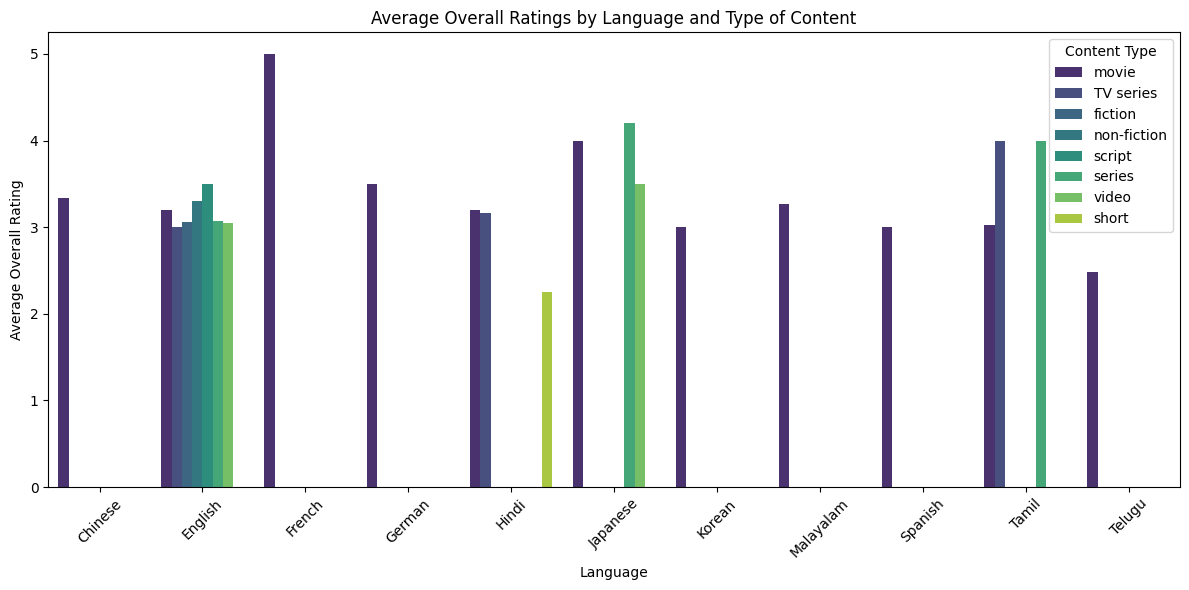

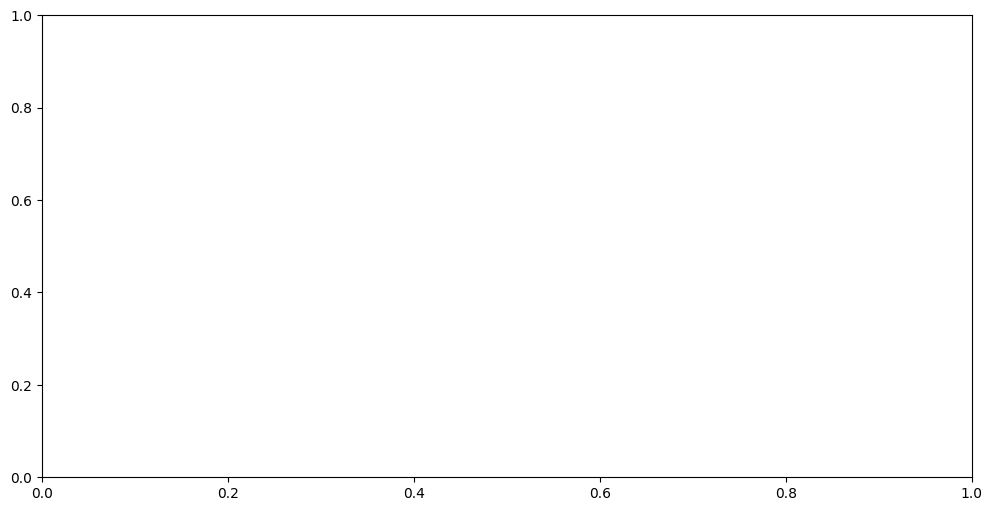

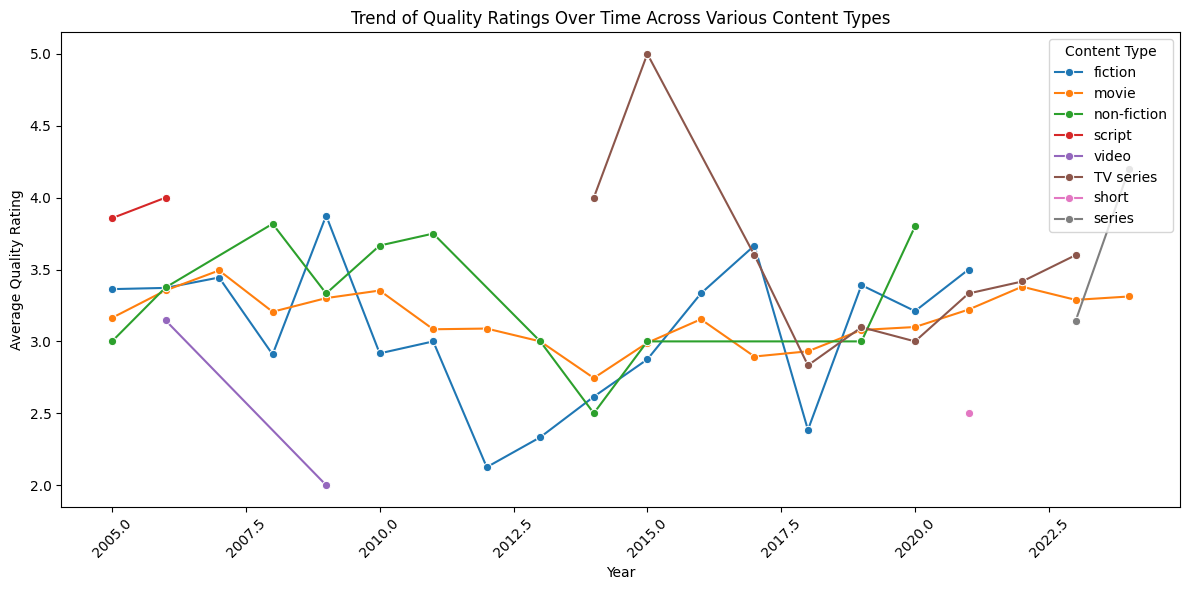

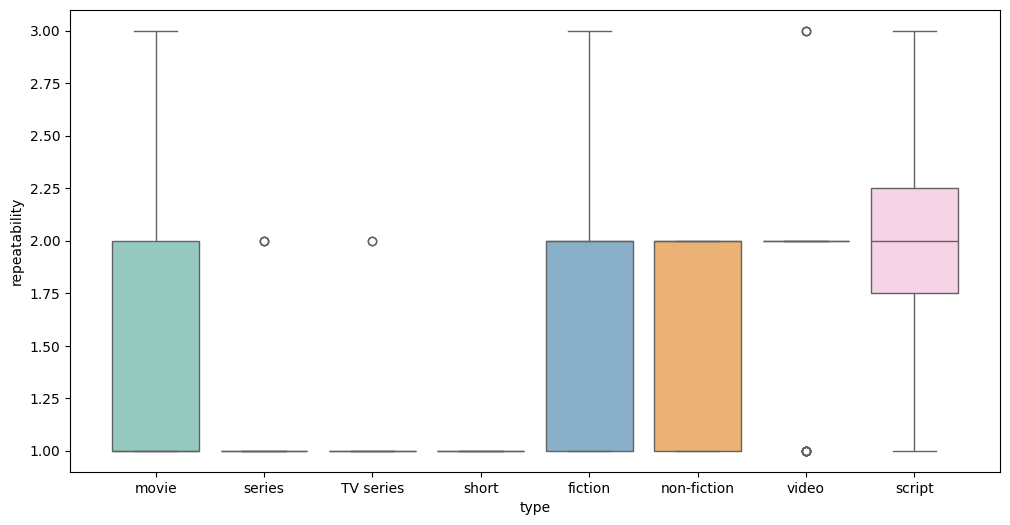

In [ ]:
#Dataset Profile
DATA_PROFILE = {}
DATA_PROFILE['llm_infered_columns'] = column_metadata
DATA_PROFILE['shape'] = df.shape
DATA_PROFILE['describe'] = df.describe(include='all').to_dict()

DATA_PROFILE_STR = json.dumps(DATA_PROFILE)

questions = get_analysis_plan(INSTRUCTIONS_TO_GENERATE_QUESTIONS, DATA_PROFILE_STR)
chartList = []
for question in questions:
    print(question)
    chart_dict = draw_charts(INSTRUCTIONS_TO_MAKE_CHARTS, question, DATA_PROFILE)
    print(chart_dict)
    chart_dict = analyse_charts(INSTRUCTIONS_TO_ANALYSE_CHARTS, question, chart_dict )
    print(chart_dict)
    chartList.append(chart_dict)
DATA_FOR_README['charts_analysis'] = chartList
print(DATA_FOR_README)
content = generate_readme(INSTRUCTIONS_TO_CREATE_README, DATA_FOR_README)
save_readme(content)

    

"{'question': 'How does the overall rating vary by language for different types of content?', 'analysis_type': 'Correlation Analysis', 'chart_type': 'Bar Chart'}"
Question : {'question': 'How does the overall rating vary by language for different types of content?', 'analysis_type': 'Correlation Analysis', 'chart_type': 'Bar Chart'}
 Some MetaData{"llm_infered_columns": [{"column_name": "date", "column_type": "date"}, {"column_name": "language", "column_type": "string"}, {"column_name": "type", "column_type": "string"}, {"column_name": "title", "column_type": "string"}, {"column_name": "by", "column_type": "string"}, {"column_name": "overall", "column_type": "integer"}, {"column_name": "quality", "column_type": "integer"}, {"column_name": "repeatability", "column_type": "integer"}], "shape": [2652, 8], "describe": {"date": {"count": 2652, "unique": 2056, "top": "Unknown", "freq": 99, "mean": NaN, "std": NaN, "min": NaN, "25%": NaN, "50%": NaN, "75%": NaN, "max": NaN}, "language": {"cou

{'question': '"{\'question\': \'How does the overall rating vary by language for different types of content?\', \'analysis_type\': \'Correlation Analysis\', \'chart_type\': \'Bar Chart\'}"',
 'file_name': 'overall_rating_by_language.png',
 'chart_name': 'Overall Rating by Language and Content Type',
 'description': 'This bar chart illustrates the average overall rating of different types of content across various languages. Each bar represents a language, and the shades indicate the type of content, allowing for a comparison of ratings and types within each language group.'}

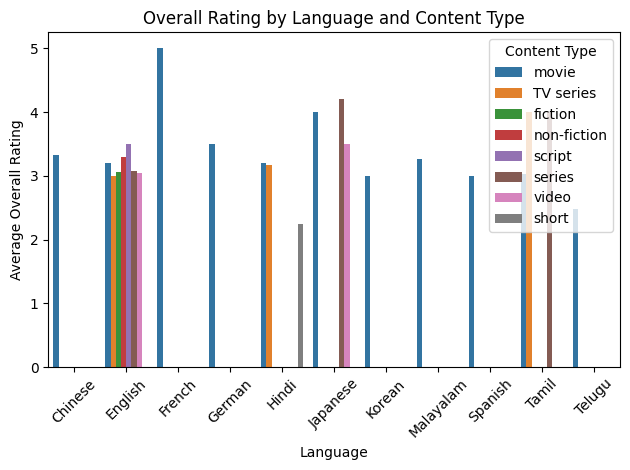

In [34]:
question = questions[0]
chart_dict = draw_charts(INSTRUCTIONS_TO_MAKE_CHARTS, question, DATA_PROFILE)
chart_dict   
#Handle Missing values 


In [43]:
analyse_charts(INSTRUCTIONS_TO_ANALYSE_CHARTS, question, chart_dict )

{'id': 'chatcmpl-AepDtSRhzPpTvKDSslhEzi5T2OM7v', 'object': 'chat.completion', 'created': 1734293385, 'model': 'gpt-4o-mini-2024-07-18', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': None, 'function_call': {'name': 'analyse_chart_generated', 'arguments': '{"insight_discovered":"The chart illustrates the average overall ratings for various types of content (movies, TV series, fiction, non-fiction, script, video, and short) across different languages. Notably, English content generally receives higher ratings compared to other languages, particularly for non-fiction and TV series. Tamil and Hindi also show competitive ratings, especially in the fiction and short content categories.","answer_to_question":"The overall ratings vary significantly by language, with English showing the highest ratings across most content types, followed by Tamil and Hindi. Other languages like Chinese and Spanish tend to have lower average ratings for the majority of content types, while 

{'question': '"{\'question\': \'How does the overall rating vary by language for different types of content?\', \'analysis_type\': \'Correlation Analysis\', \'chart_type\': \'Bar Chart\'}"',
 'file_name': 'overall_rating_by_language.png',
 'chart_name': 'Overall Rating by Language and Content Type',
 'description': 'This bar chart illustrates the average overall rating of different types of content across various languages. Each bar represents a language, and the shades indicate the type of content, allowing for a comparison of ratings and types within each language group.',
 'analysis': '{"insight_discovered":"The chart illustrates the average overall ratings for various types of content (movies, TV series, fiction, non-fiction, script, video, and short) across different languages. Notably, English content generally receives higher ratings compared to other languages, particularly for non-fiction and TV series. Tamil and Hindi also show competitive ratings, especially in the fiction a

In [ ]:
import requests
import os
import pandas as pd
import json
import traceback
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Define global variables
AIPROXY_TOKEN = os.environ.get("AIPROXY_TOKEN")
URL = "https://aiproxy.sanand.workers.dev/openai/v1/chat/completions"
HEADERS = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {AIPROXY_TOKEN}"
}
INSTRUCTIONS_TO_MAKE_CHARTS = (
    "You are provided with a dataset loaded in a dataframe named `df`, along with its metadata. "
    "Your task is to analyze the dataset and create a chart that answers the provided question or illustrates the relevant insight. "
    "The dataset is huge; consider the chart type and axes carefully. "
    "Aggregate or filter data if necessary, and export the chart as a PNG file. "
    "Use matplotlib or seaborn libraries for plotting. Ensure the chart is labeled and easy to interpret."
)
INSTRUCTIONS_TO_INFER_COLUMNS = (
"Analyse the given dataset. The first line is the header, and subsequent lines "
"are sample data. Columns may have uncleaned data; ignore those cells. "
"consider column as the data type of column"
"Infer the data type by considering the majority: 'integer', 'float', 'string', 'boolean', and 'date'."
)

def get_aiproxy_token():
    """Fetch the AI Proxy token from environment variables."""
    if not AIPROXY_TOKEN:
        raise ValueError("AIPROXY_TOKEN not found in environment variables.")
    return AIPROXY_TOKEN

def read_sample_data(file_name, lines=10):
    """Read and return the first few lines of the dataset as a string."""
    with open(file=file_name, mode='r') as f:
        return ''.join([f.readline().strip() for _ in range(lines)])

def load_csv_with_fallback(file_name, encodings=['utf-8', 'ISO-8859-1', 'latin1']):
    """Attempt to load a CSV file with multiple encodings."""
    for encoding in encodings:
        try:
            df = pd.read_csv(file_name, encoding=encoding)
            print(f"Successfully loaded with encoding: {encoding}")
            return df
        except UnicodeDecodeError as e:
            print(f"Failed to load with encoding: {encoding}, error: {e}")
    raise UnicodeDecodeError(f"All attempts to load the file {file_name} with the provided encodings failed.")

def infer_column_types(content, data):
    """Infer column data types using the AI API."""
    json_data = {
        "model": "gpt-4o-mini",
        "messages": [
            {"role": "system", "content": content},
            {"role": "user", "content": data}
        ],
        "functions": [
            {
                "name": "get_column_type",
                "description": "Identify column names and their data type from the dataset",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "column_metadata": {
                            "type": "array",
                            "description": "Metadata for each column",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "column_name": {"type": "string", "description": "The name of the column"},
                                    "column_type": {"type": "string", "description": "The data type of the column"}
                                },
                                "required": ["column_name", "column_type"]
                            },
                            "minItems": 1
                        },
                        "dataset_overview": {
                            "type": "string",
                            "description": "Overview of the dataset and its structure"
                        }
                    },
                    "required": ["column_metadata", "dataset_overview"]
                }
            }
        ],
        "function_call": {"name": "get_column_type"}
    }

    try:
        response = requests.post(url=URL, headers=HEADERS, json=json_data)
        response.raise_for_status()
        result = response.json()
        metadata = json.loads(result['choices'][0]['message']['function_call']['arguments'])
        return metadata['column_metadata'], metadata['dataset_overview']
    except requests.exceptions.RequestException as e:
        print(f"HTTP Request failed: {e}")
        raise
    except KeyError as e:
        print(f"Unexpected response format: {e}")
        raise

def correct_the_code(code, error, meta_data, instructions, functions, function_name="generate_chart"):
    """Send a code snippet and error details to the AI API for correction."""
    code_with_error = code + "\n" + error + "\n" + str(meta_data)
    json_data = {
        "model": "gpt-4o-mini",
        "messages": [
            {"role": "system", "content": instructions},
            {"role": "user", "content": code_with_error}
        ],
        "functions": functions,
        "function_call": {"name": function_name}
    }
    response = requests.post(URL, headers=HEADERS, json=json_data)
    return response.json()

def execute_code(code, meta_data, instructions, functions, function_name="generate_chart", attempts=3):
    """Execute the provided code with retry logic."""
    attempt = 0
    success = False

    while attempt < attempts and not success:
        try:
            exec(code)
            success = True
        except Exception as e:
            attempt += 1
            print(f"Attempt {attempt} failed: {e}")
            error = traceback.format_exc()
            print(error)
            response = correct_the_code(code, error, meta_data, instructions, functions,function_name)
            code = json.loads(response['choices'][0]['message']['function_call']['arguments'])['python_code']

    if not success:
        print("All attempts to execute the code failed.")

def handle_missing_values_llm(df, meta_data):
    """Handle missing values using LLM suggestions."""
    try:
        missing_values = df.isnull().sum()
        print("\nMissing Values:\n", missing_values)
        functions = [
            {
                "name": "handle_missing_values",
                "description": "Handle missing values in the dataset",
                "parameters" : {
                    "type": "object",
                    "required": ["python_code", "dependencies","steps_taken_to_handle_mv"],
                    "properties" :{
                        "python_code" :{
                            "type": "string",
                            "description": "Python code to handle missing values in the dataset"
                        },
                        "dependencies":{
                            "type": "string",
                            "description": "comma separated list of dependencies used to preprocess this chart"

                        },
                        "steps_taken_to_handle_mv":{
                            "type": "string",
                            "description": "Elaborative description of Steps taken to handle missing values in the dataset"

                        },

                    }
                
                }

            }
        ]
        instructions_to_handle_missing_values = (
            "The dataset has been already loaded in the environment as a pandas dataframe 'df'. "
            "The dataset may have missing values. Handle the missing values in the dataset. "
            "The dataset is huge the selection of chart type and axes must be considered accordingly . "
            "You have to generate Python code to handle missing values in the dataset. The code should not contain any comments. "
            "The handling of missing values should consider the data type of the column as well as the context and semantics of the data. "
            "Your choice of handling missing values should be logical and based on the column's meaning and its relevance to the dataset's domain. "
            "Think of it as what would a data scientist do in this situation. How does it impact the analysis and if its retention in data convey some meaning"
            "You can use the following libraries: pandas. "
            "The code should be generic, adaptable to any dataset, and should not rely on hardcoding column names. "
            "The column names and data types of the dataset are provided in the metadata. "
        )


        prompt = (
            "### Missing Values Data:\n" + str(missing_values) + "\n"
            "### Metadata of the Dataset:\n" + str(meta_data) + "\n\n"
            "Your task:\n"
            "1. Handle only those columns which have missing values.\n"
            "2. Use logical and context-aware methods to handle missing values:\n"
            "   - For numeric columns, choose strategies such as mean, median, or interpolation based on the column's context and relevance. Reason its importance in the dataset.\n"
            "   - For categorical columns, consider using the mode, 'Unknown', or another domain-specific default value where applicable. Think of the implications it would have\n"
            "   - If the column contains data with domain-specific meaning (e.g., 'Country', 'Happiness Score'), avoid generic imputations (like the global mean) and choose approaches that respect the data's semantics. For instance, consider using regional or grouped means or flagging missing values instead of filling them.\n"
            "   - You may consider dropping columns with a high percentage of missing values if they are not relevant to the analysis.\n"
            "  - Ensure that the handling of missing values aligns with the context of the data and the domain of the dataset.\n"
            " - You may consider dropping rows with missing values if they are not significant in number and do not affect the analysis.\n"
            "3. Provide clear reasoning for every step taken to handle missing values in the dataset, ensuring it aligns with the context of the data.\n\n"
            "### Additional Notes:\n"
            "The Python code must be generic and should work for any dataset. It should not hardcode column names and should dynamically handle missing values based on the provided metadata."
        )

        json_data = {
            "model": "gpt-4o-mini",
            "messages": [
                {
                    "role": "system",
                    "content": instructions_to_handle_missing_values
                },
                {
                    "role": "user",
                    "content": prompt
        }
            ],
            "functions": functions,
            "function_call" :{"name": "handle_missing_values"}
        }
        r = requests.post(URL, headers=HEADERS, json=json_data)
        response = r.json()
        print(response)
        code = json.loads(response['choices'][0]['message']['function_call']['arguments'])['python_code']
        print(code)
        execute_code(code, meta_data, instructions_to_handle_missing_values, functions,function_name="handle_missing_values"  )
        print(df.isnull().sum())
        logic = json.loads(response['choices'][0]['message']['function_call']['arguments'])['steps_taken_to_handle_mv']
        print(logic)
    
    except Exception as e:
        print(f"Error in handling missing values with LLM: {e}")
        raise

def main():
    """Main function to handle the dataset analysis workflow."""
    # Load dataset
    file_name = sys.argv[1]
    df = load_csv_with_fallback(file_name)
    sample_data = read_sample_data(file_name)
    print("Dataset Loaded")
    print(sample_data)

    # Infer metadata
    meta_data, overview = infer_column_types(INSTRUCTIONS_TO_MAKE_CHARTS, sample_data)
    print("MetaData Extracted:", meta_data)
    print("Dataset Overview:", overview)

    # Handle missing values
    print("\nMissing Values Before Handling:\n", df.isnull().sum())
    handle_missing_values_llm(df, meta_data)
    print("\nMissing Values After Handling:\n", df.isnull().sum())

    #Extract Analysis Questions 


    #Draw Charts to answer analysis questions


    #Make Readme File



if __name__ == "__main__":
    main()
